In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import Point, Polygon as ShapelyPolygon, MultiPolygon
from shapely.ops import unary_union
import warnings
import os
import datetime
from tqdm import tqdm

# Suppress Shapely warnings which are common with complex unions/intersections
warnings.filterwarnings('ignore')

# --- Helper Function to plot and save Shapely polygons ---
def plot_shapely_polygon(ax, poly, facecolor, edgecolor='black', alpha=0.5, label=None):
    """Helper function to plot a Shapely Polygon or MultiPolygon on a matplotlib axis."""
    if poly.is_empty:
        return
    if isinstance(poly, MultiPolygon):
        for p in poly.geoms:
            x, y = p.exterior.xy
            ax.fill(x, y, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, label=label)
            # In a multipolygon, only label the first part to avoid legend duplication
            if label:
                label = None
    else: # It's a single Polygon
        x, y = poly.exterior.xy
        ax.fill(x, y, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, label=label)

class VoronoiTransitionZone:
    def __init__(self, space_bounds=(-10, 10, -10, 10), resolution=200, output_dir='output'):
        """
        Initialize the Voronoi transition zone analyzer.

        Parameters:
        - space_bounds: (xmin, xmax, ymin, ymax) bounds of the space
        - resolution: grid resolution for rasterization
        - output_dir: Directory to save generated images and logs.
        """
        self.xmin, self.xmax, self.ymin, self.ymax = space_bounds
        self.resolution = resolution
        self.output_dir = output_dir

        # Create bounding box as a shapely polygon
        self.bounding_box = ShapelyPolygon([
            (self.xmin, self.ymin),
            (self.xmax, self.ymin),
            (self.xmax, self.ymax),
            (self.xmin, self.ymax)
        ])

        print("="*50)
        print("VoronoiTransitionZone Initialized")
        print(f"Space Bounds: x in [{self.xmin}, {self.xmax}], y in [{self.ymin}, {self.ymax}]")
        print(f"Bounding Box Area: {self.bounding_box.area:.2f}")
        print(f"Output will be saved in: '{self.output_dir}'")
        print("="*50)

    def sample_from_disk(self, center, radius, n_samples=100):
        """Sample random points uniformly from a disk."""
        angles = np.random.uniform(0, 2*np.pi, n_samples)
        radii = radius * np.sqrt(np.random.uniform(0, 1, n_samples))
        x = center[0] + radii * np.cos(angles)
        y = center[1] + radii * np.sin(angles)
        return np.column_stack((x, y))

    def sample_from_square(self, center, side_length, angle=0, n_samples=100):
        """Sample random points uniformly from a square (possibly rotated)."""
        x = np.random.uniform(-side_length/2, side_length/2, n_samples)
        y = np.random.uniform(-side_length/2, side_length/2, n_samples)
        points = np.column_stack((x, y))

        if angle != 0:
            cos_a, sin_a = np.cos(angle), np.sin(angle)
            rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
            points = points @ rotation_matrix.T

        points += center
        return points

    def compute_halfplane(self, a, b):
        """
        Compute the half-plane H(a, b) containing points closer to a than to b.
        Returns the coefficients (A, B, C) such that Ax + By + C <= 0 defines the half-plane.
        """
        midpoint = (a + b) / 2
        direction = a - b

        # The half-plane equation is (a-b) · (x - (a+b)/2) <= 0
        # (a_x-b_x)(x - (a_x+b_x)/2) + (a_y-b_y)(y - (a_y+b_y)/2) <= 0
        # (a_x-b_x)x + (a_y-b_y)y - [(a_x-b_x)(a_x+b_x)/2 + (a_y-b_y)(a_y+b_y)/2] <= 0
        # (a_x-b_x)x + (a_y-b_y)y - [ (a_x^2 - b_x^2)/2 + (a_y^2 - b_y^2)/2 ] <= 0
        # (a_x-b_x)x + (a_y-b_y)y - ( ||a||^2 - ||b||^2 ) / 2 <= 0
        A = direction[0]
        B = direction[1]
        C = -(np.dot(a, a) - np.dot(b, b)) / 2

        return A, B, C

    def halfplane_to_polygon(self, A, B, C):
        """
        Convert a half-plane Ax + By + C <= 0 to a polygon by intersecting with the bounding box.
        This uses a more robust method by constructing a large polygon guaranteed to contain
        the correct side and then intersecting it with the bounding box.
        """
        # A large value to extend the polygon beyond the bounds
        large_val = 2 * (abs(self.xmax - self.xmin) + abs(self.ymax - self.ymin))

        # Points on the line Ax + By + C = 0
        p1, p2 = [0,0], [0,0]
        if abs(B) > abs(A): # More horizontal line
            p1 = (self.xmin - large_val, (-C - A*(self.xmin - large_val)) / B)
            p2 = (self.xmax + large_val, (-C - A*(self.xmax + large_val)) / B)
        else: # More vertical line
            p1 = ((-C - B*(self.ymin - large_val)) / A, self.ymin - large_val)
            p2 = ((-C - B*(self.ymax + large_val)) / A, self.ymax + large_val)

        # A third point, far away, to define the half-plane side
        # The normal vector (A, B) points to the side where Ax+By+C > 0
        # We want the side Ax+By+C <= 0, so we move in the direction (-A, -B)
        p3 = ((p1[0]+p2[0])/2 - A*large_val, (p1[1]+p2[1])/2 - B*large_val)

        try:
            half_space_poly = ShapelyPolygon([p1, p2, p3])
            return self.bounding_box.intersection(half_space_poly)
        except Exception as e:
            print(f"  [Warning] Shapely polygon creation failed: {e}. Returning empty polygon.")
            return ShapelyPolygon()

    def _visualize_component_construction(self, polygons, final_region, title, output_path):
        """Visualizes the construction of a region from its component half-planes."""
        fig, ax = plt.subplots(figsize=(8, 8))

        # Plot individual half-plane polygons with low alpha
        for poly in polygons:
            plot_shapely_polygon(ax, poly, facecolor='cyan', alpha=0.05)

        # Plot the final resulting region (union or intersection) on top
        plot_shapely_polygon(ax, final_region, facecolor='purple', alpha=0.6, edgecolor='black')

        ax.set_xlim(self.xmin, self.xmax)
        ax.set_ylim(self.ymin, self.ymax)
        ax.set_aspect('equal')
        ax.set_title(title)
        ax.grid(True, linestyle='--', alpha=0.4)

        plt.savefig(output_path)
        plt.close(fig)
        print(f"  Saved component construction visualization to: {output_path}")

    def calculate_transition_zone_area(self, points_A, points_B, run_id, visualize_final=False, visualize_steps=False):
        """
        Calculate the area of the Voronoi transition zone F_AB using Formulation 2 (more stable).
        Formulation 2: F_AB = U_A ∩ U_B, where U_A is the union of H(a,b) and U_B is the union of H(b,a).

        Parameters:
        - points_A: array of points from region A
        - points_B: array of points from region B
        - run_id: A unique string identifier for this calculation run.
        - visualize_final: If True, creates a final summary visualization.
        - visualize_steps: If True, visualizes the construction of U_A and U_B.

        Returns:
        - area: area of the transition zone
        - transition_zone: Shapely polygon representing the transition zone
        """
        print(f"\n--- Starting Calculation for run_id: {run_id} ---")
        print(f"Number of points in A: {len(points_A)}, B: {len(points_B)}")
        print("Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))")

        # --- Compute U_A: union of all H(a_i, b_j) ---
        print("\nStep 1: Computing U_A = Union of all H(a,b)")
        U_A_polygons = []
        for i, a in enumerate(points_A):
            for j, b in enumerate(points_B):
                A, B, C = self.compute_halfplane(a, b)
                poly = self.halfplane_to_polygon(A, B, C)
                if not poly.is_empty:
                    U_A_polygons.append(poly)

        U_A = unary_union(U_A_polygons) if U_A_polygons else ShapelyPolygon()
        print(f"  Computed {len(U_A_polygons)} half-planes for U_A.")
        print(f"  Area of U_A: {U_A.area:.2f}")
        if visualize_steps and not U_A.is_empty:
            path = os.path.join(self.output_dir, f"{run_id}_step1_UA_construction.png")
            self._visualize_component_construction(U_A_polygons, U_A, 'Construction of U_A (Union of H(a,b))', path)

        # --- Compute U_B: union of all H(b_j, a_i) ---
        print("\nStep 2: Computing U_B = Union of all H(b,a)")
        U_B_polygons = []
        for b in points_B:
            for a in points_A:
                A, B, C = self.compute_halfplane(b, a)
                poly = self.halfplane_to_polygon(A, B, C)
                if not poly.is_empty:
                    U_B_polygons.append(poly)

        U_B = unary_union(U_B_polygons) if U_B_polygons else ShapelyPolygon()
        print(f"  Computed {len(U_B_polygons)} half-planes for U_B.")
        print(f"  Area of U_B: {U_B.area:.2f}")
        if visualize_steps and not U_B.is_empty:
            path = os.path.join(self.output_dir, f"{run_id}_step2_UB_construction.png")
            self._visualize_component_construction(U_B_polygons, U_B, 'Construction of U_B (Union of H(b,a))', path)

        # --- Transition zone is the intersection ---
        print("\nStep 3: Computing Transition Zone F_AB = U_A ∩ U_B")
        transition_zone = U_A.intersection(U_B)
        area = transition_zone.area
        print(f"  Area of Transition Zone F_AB: {area:.2f}")

        if visualize_final or visualize_steps:
            path = os.path.join(self.output_dir, f"{run_id}_step3_final_result.png")
            self._visualize_final_result(points_A, points_B, transition_zone, U_A, U_B, path)

        print(f"--- Calculation for {run_id} Complete ---")
        return area, transition_zone

    def _visualize_final_result(self, points_A, points_B, transition_zone, U_A, U_B, output_path):
        """Create a detailed visualization of the final result."""
        fig, ax = plt.subplots(figsize=(10, 10))

        # Plot U_A and U_B regions
        plot_shapely_polygon(ax, U_A, facecolor='red', alpha=0.1, label='U_A Region')
        plot_shapely_polygon(ax, U_B, facecolor='blue', alpha=0.1, label='U_B Region')

        # Plot the transition zone (their intersection)
        plot_shapely_polygon(ax, transition_zone, facecolor='purple', alpha=0.6, edgecolor='black', label='Transition Zone (F_AB)')

        # Plot points
        ax.scatter(points_A[:, 0], points_A[:, 1], c='red', s=50, alpha=0.9,
                   label='Points A', edgecolors='darkred', zorder=5)
        ax.scatter(points_B[:, 0], points_B[:, 1], c='blue', s=50, alpha=0.9,
                   label='Points B', edgecolors='darkblue', zorder=5)

        ax.set_xlim(self.xmin, self.xmax)
        ax.set_ylim(self.ymin, self.ymax)
        ax.set_aspect('equal')
        title = f'Voronoi Transition Zone\nArea: {transition_zone.area:.2f}'
        ax.set_title(title, fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(loc='upper right')

        plt.tight_layout()
        plt.savefig(output_path, dpi=150)
        plt.close(fig)
        print(f"  Saved final visualization to: {output_path}")

def experiment_vary_radius(vtz, center_A, center_B, radii_range, fixed_radius_B=1.0,
                          n_samples=20, n_trials=5):
    """Experiment 1: Vary the radius of region A while keeping B fixed."""
    print("\n" + "="*20 + " Experiment 1: Varying Radius " + "="*20)
    results = []

    for r_A in tqdm(radii_range, desc="Exp 1: Varying radius A"):
        areas = []
        for i in range(n_trials):
            points_A = vtz.sample_from_disk(center_A, r_A, n_samples)
            points_B = vtz.sample_from_disk(center_B, fixed_radius_B, n_samples)

            # Visualize only the first trial for each parameter setting
            visualize = (i == 0)
            run_id = f"exp1_radiusA_{r_A:.2f}_trial_{i}"

            area, _ = vtz.calculate_transition_zone_area(points_A, points_B, run_id, visualize_final=visualize)
            areas.append(area)

        results.append({
            'radius_A': r_A,
            'area_mean': np.mean(areas),
            'area_std': np.std(areas)
        })
    return results

def experiment_vary_distance(vtz, radius_A, radius_B, distances, n_samples=20, n_trials=5):
    """Experiment 2: Vary the distance between regions."""
    print("\n" + "="*20 + " Experiment 2: Varying Distance " + "="*20)
    results = []

    for d in tqdm(distances, desc="Exp 2: Varying distance"):
        areas = []
        center_A = (-d/2, 0)
        center_B = (d/2, 0)

        for i in range(n_trials):
            points_A = vtz.sample_from_disk(center_A, radius_A, n_samples)
            points_B = vtz.sample_from_disk(center_B, radius_B, n_samples)

            visualize = (i == 0)
            run_id = f"exp2_dist_{d:.2f}_trial_{i}"

            area, _ = vtz.calculate_transition_zone_area(points_A, points_B, run_id, visualize_final=visualize)
            areas.append(area)

        results.append({
            'distance': d,
            'area_mean': np.mean(areas),
            'area_std': np.std(areas)
        })
    return results

def experiment_vary_orientation(vtz, center_A, center_B, side_length, angles,
                               n_samples=20, n_trials=5):
    """Experiment 3: Vary the orientation of square B relative to A."""
    print("\n" + "="*20 + " Experiment 3: Varying Orientation " + "="*20)
    results = []

    for angle in tqdm(angles, desc="Exp 3: Varying orientation"):
        areas = []
        for i in range(n_trials):
            points_A = vtz.sample_from_square(center_A, side_length, angle=0, n_samples=n_samples)
            points_B = vtz.sample_from_square(center_B, side_length, angle=angle, n_samples=n_samples)

            visualize = (i == 0)
            run_id = f"exp3_angle_{np.degrees(angle):.1f}_trial_{i}"

            area, _ = vtz.calculate_transition_zone_area(points_A, points_B, run_id, visualize_final=visualize)
            areas.append(area)

        results.append({
            'angle': np.degrees(angle),
            'area_mean': np.mean(areas),
            'area_std': np.std(areas)
        })
    return results

def plot_results(results, x_key, x_label, title, output_path):
    """Plot experimental results with error bars and save to file."""
    x_values = [r[x_key] for r in results]
    y_means = [r['area_mean'] for r in results]
    y_stds = [r['area_std'] for r in results]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.errorbar(x_values, y_means, yerr=y_stds, fmt='o-', capsize=5, capthick=2,
                markersize=8, linewidth=2, label='Mean Area ± Std Dev')
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Transition Zone Area', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3)

    correlation = np.corrcoef(x_values, y_means)[0, 1]
    ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
             transform=ax.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             fontsize=12)

    ax.legend()
    plt.tight_layout()
    plt.savefig(output_path, dpi=150)
    plt.close(fig)
    print(f"\nSaved summary plot to: {output_path}")

# Main execution
if __name__ == "__main__":
    # --- Setup ---
    # Create a unique output directory for this run
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"output_voronoi_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    # Initialize the analyzer
    vtz = VoronoiTransitionZone(space_bounds=(-10, 10, -10, 10), output_dir=output_dir)

    # --- Example Visualization (with full details) ---
    print("\n" + "#"*20 + " Detailed Example Run " + "#"*20)
    points_A = vtz.sample_from_disk(center=(-5, 0), radius=2, n_samples=5)
    points_B = vtz.sample_from_disk(center=(5, 0), radius=1.5, n_samples=5)
    area, _ = vtz.calculate_transition_zone_area(
        points_A,
        points_B,
        run_id="detailed_example",
        visualize_final=True,
        visualize_steps=True
    )
    print(f"\nFinal area for detailed example: {area:.2f}")

    # --- Experiment 1: Vary radius ---
    results_radius = experiment_vary_radius(vtz, center_A=(-4, 0), center_B=(4, 0),
                                          radii_range=np.linspace(0.5, 3.0, 5),
                                          fixed_radius_B=1.5,
                                          n_samples=10, n_trials=3)
    plot_results(results_radius, 'radius_A', 'Radius of Region A',
                'Transition Zone Area vs. Region Size',
                os.path.join(output_dir, "summary_exp1_radius.png"))

    # --- Experiment 2: Vary distance ---
    results_distance = experiment_vary_distance(vtz, radius_A=1.5, radius_B=1.5,
                                              distances=np.linspace(5.0, 12.0, 5),
                                              n_samples=10, n_trials=3)
    plot_results(results_distance, 'distance', 'Distance Between Centers',
                'Transition Zone Area vs. Distance',
                os.path.join(output_dir, "summary_exp2_distance.png"))

    # --- Experiment 3: Vary orientation (for squares) ---
    results_orientation = experiment_vary_orientation(vtz, center_A=(-4, 0), center_B=(4, 0),
                                                    side_length=3, angles=np.linspace(0, np.pi/2, 5),
                                                    n_samples=10, n_trials=3)
    plot_results(results_orientation, 'angle', 'Rotation Angle (degrees)',
                'Transition Zone Area vs. Relative Orientation',
                os.path.join(output_dir, "summary_exp3_orientation.png"))

    print(f"\nAll experiments complete. All outputs saved in '{output_dir}'.")

VoronoiTransitionZone Initialized
Space Bounds: x in [-10, 10], y in [-10, 10]
Bounding Box Area: 400.00
Output will be saved in: 'output_voronoi_20250807_210329'

#################### Detailed Example Run ####################

--- Starting Calculation for run_id: detailed_example ---
Number of points in A: 5, B: 5
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 25 half-planes for U_A.
  Area of U_A: 242.01
  Saved component construction visualization to: output_voronoi_20250807_210329/detailed_example_step1_UA_construction.png

Step 2: Computing U_B = Union of all H(b,a)
  Computed 25 half-planes for U_B.
  Area of U_B: 216.72
  Saved component construction visualization to: output_voronoi_20250807_210329/detailed_example_step2_UB_construction.png

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 58.73
  Saved final visualization to: output_voronoi_20250807_210329/detailed_example_ste

Exp 1: Varying radius A:   0%|          | 0/5 [00:00<?, ?it/s]


--- Starting Calculation for run_id: exp1_radiusA_0.50_trial_0 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 224.42

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 223.01

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 47.42


Exp 1: Varying radius A:  20%|██        | 1/5 [00:01<00:05,  1.49s/it]

  Saved final visualization to: output_voronoi_20250807_210329/exp1_radiusA_0.50_trial_0_step3_final_result.png
--- Calculation for exp1_radiusA_0.50_trial_0 Complete ---

--- Starting Calculation for run_id: exp1_radiusA_0.50_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 218.71

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 227.60

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 46.31
--- Calculation for exp1_radiusA_0.50_trial_1 Complete ---

--- Starting Calculation for run_id: exp1_radiusA_0.50_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 226.29

Step 2: Computing U_B = Union of all H(b,a)
  Co

Exp 1: Varying radius A:  40%|████      | 2/5 [00:03<00:05,  1.86s/it]

  Computed 100 half-planes for U_A.
  Area of U_A: 238.00

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 236.40

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 74.40
--- Calculation for exp1_radiusA_1.12_trial_2 Complete ---

--- Starting Calculation for run_id: exp1_radiusA_1.75_trial_0 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 239.26

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 240.28

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 79.54
  Saved final visualization to: output_voronoi_20250807_210329/exp1_radiusA_1.75_trial_0_step3_final_result.png
--- Calculation for exp1_radiusA_1.75_trial_0 Complete ---

--- Starting Calculation for run_id: exp1_radiusA_1.75_trial_

Exp 1: Varying radius A:  60%|██████    | 3/5 [00:06<00:04,  2.12s/it]

  Area of Transition Zone F_AB: 76.56
--- Calculation for exp1_radiusA_1.75_trial_2 Complete ---

--- Starting Calculation for run_id: exp1_radiusA_2.38_trial_0 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 260.19

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 251.25

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 111.43


Exp 1: Varying radius A:  80%|████████  | 4/5 [00:07<00:01,  1.95s/it]

  Saved final visualization to: output_voronoi_20250807_210329/exp1_radiusA_2.38_trial_0_step3_final_result.png
--- Calculation for exp1_radiusA_2.38_trial_0 Complete ---

--- Starting Calculation for run_id: exp1_radiusA_2.38_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 253.63

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 255.37

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 109.00
--- Calculation for exp1_radiusA_2.38_trial_1 Complete ---

--- Starting Calculation for run_id: exp1_radiusA_2.38_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 250.88

Step 2: Computing U_B = Union of all H(b,a)
  C

Exp 1: Varying radius A: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]

  Saved final visualization to: output_voronoi_20250807_210329/exp1_radiusA_3.00_trial_0_step3_final_result.png
--- Calculation for exp1_radiusA_3.00_trial_0 Complete ---

--- Starting Calculation for run_id: exp1_radiusA_3.00_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 246.91

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 244.38

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 91.28
--- Calculation for exp1_radiusA_3.00_trial_1 Complete ---

--- Starting Calculation for run_id: exp1_radiusA_3.00_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 249.33

Step 2: Computing U_B = Union of all H(b,a)
  Co


Saved summary plot to: output_voronoi_20250807_210329/summary_exp1_radius.png

==================== Experiment 2: Varying Distance ====================


Exp 2: Varying distance:   0%|          | 0/5 [00:00<?, ?it/s]


--- Starting Calculation for run_id: exp2_dist_5.00_trial_0 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 251.05

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 249.17

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 100.21


Exp 2: Varying distance:  20%|██        | 1/5 [00:00<00:02,  1.38it/s]

  Saved final visualization to: output_voronoi_20250807_210329/exp2_dist_5.00_trial_0_step3_final_result.png
--- Calculation for exp2_dist_5.00_trial_0 Complete ---

--- Starting Calculation for run_id: exp2_dist_5.00_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 258.35

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 252.49

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 110.84
--- Calculation for exp2_dist_5.00_trial_1 Complete ---

--- Starting Calculation for run_id: exp2_dist_5.00_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 252.96

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 hal

Exp 2: Varying distance:  40%|████      | 2/5 [00:01<00:02,  1.34it/s]

  Saved final visualization to: output_voronoi_20250807_210329/exp2_dist_6.75_trial_0_step3_final_result.png
--- Calculation for exp2_dist_6.75_trial_0 Complete ---

--- Starting Calculation for run_id: exp2_dist_6.75_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 245.69

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 237.17

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 82.86
--- Calculation for exp2_dist_6.75_trial_1 Complete ---

--- Starting Calculation for run_id: exp2_dist_6.75_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 245.89

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half

Exp 2: Varying distance:  60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

  Saved final visualization to: output_voronoi_20250807_210329/exp2_dist_8.50_trial_0_step3_final_result.png
--- Calculation for exp2_dist_8.50_trial_0 Complete ---

--- Starting Calculation for run_id: exp2_dist_8.50_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 243.22

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 233.80

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 77.03
--- Calculation for exp2_dist_8.50_trial_1 Complete ---

--- Starting Calculation for run_id: exp2_dist_8.50_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 240.26

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half

Exp 2: Varying distance:  80%|████████  | 4/5 [00:02<00:00,  1.38it/s]

  Saved final visualization to: output_voronoi_20250807_210329/exp2_dist_10.25_trial_0_step3_final_result.png
--- Calculation for exp2_dist_10.25_trial_0 Complete ---

--- Starting Calculation for run_id: exp2_dist_10.25_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 233.07

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 238.62

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 71.69
--- Calculation for exp2_dist_10.25_trial_1 Complete ---

--- Starting Calculation for run_id: exp2_dist_10.25_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 230.93

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100

Exp 2: Varying distance: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

  Saved final visualization to: output_voronoi_20250807_210329/exp2_dist_12.00_trial_0_step3_final_result.png
--- Calculation for exp2_dist_12.00_trial_0 Complete ---

--- Starting Calculation for run_id: exp2_dist_12.00_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 230.18

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 224.66

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 54.84
--- Calculation for exp2_dist_12.00_trial_1 Complete ---

--- Starting Calculation for run_id: exp2_dist_12.00_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 229.68

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100


Saved summary plot to: output_voronoi_20250807_210329/summary_exp2_distance.png

==================== Experiment 3: Varying Orientation ====================


Exp 3: Varying orientation:   0%|          | 0/5 [00:00<?, ?it/s]


--- Starting Calculation for run_id: exp3_angle_0.0_trial_0 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 248.74

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 246.21

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 94.96


Exp 3: Varying orientation:  20%|██        | 1/5 [00:00<00:03,  1.32it/s]

  Saved final visualization to: output_voronoi_20250807_210329/exp3_angle_0.0_trial_0_step3_final_result.png
--- Calculation for exp3_angle_0.0_trial_0 Complete ---

--- Starting Calculation for run_id: exp3_angle_0.0_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 250.15

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 251.98

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 102.13
--- Calculation for exp3_angle_0.0_trial_1 Complete ---

--- Starting Calculation for run_id: exp3_angle_0.0_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 244.26

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 hal

Exp 3: Varying orientation:  40%|████      | 2/5 [00:01<00:02,  1.32it/s]

  Saved final visualization to: output_voronoi_20250807_210329/exp3_angle_22.5_trial_0_step3_final_result.png
--- Calculation for exp3_angle_22.5_trial_0 Complete ---

--- Starting Calculation for run_id: exp3_angle_22.5_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 251.53

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 244.20

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 95.73
--- Calculation for exp3_angle_22.5_trial_1 Complete ---

--- Starting Calculation for run_id: exp3_angle_22.5_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 235.55

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100

Exp 3: Varying orientation:  60%|██████    | 3/5 [00:02<00:01,  1.36it/s]

  Saved final visualization to: output_voronoi_20250807_210329/exp3_angle_45.0_trial_0_step3_final_result.png
--- Calculation for exp3_angle_45.0_trial_0 Complete ---

--- Starting Calculation for run_id: exp3_angle_45.0_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 237.53

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 246.17

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 83.70
--- Calculation for exp3_angle_45.0_trial_1 Complete ---

--- Starting Calculation for run_id: exp3_angle_45.0_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 246.06

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100

Exp 3: Varying orientation:  80%|████████  | 4/5 [00:03<00:00,  1.32it/s]

  Saved final visualization to: output_voronoi_20250807_210329/exp3_angle_67.5_trial_0_step3_final_result.png
--- Calculation for exp3_angle_67.5_trial_0 Complete ---

--- Starting Calculation for run_id: exp3_angle_67.5_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 250.64

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 253.55

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 104.19
--- Calculation for exp3_angle_67.5_trial_1 Complete ---

--- Starting Calculation for run_id: exp3_angle_67.5_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 244.69

Step 2: Computing U_B = Union of all H(b,a)
  Computed 10

Exp 3: Varying orientation: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

  Saved final visualization to: output_voronoi_20250807_210329/exp3_angle_90.0_trial_0_step3_final_result.png
--- Calculation for exp3_angle_90.0_trial_0 Complete ---

--- Starting Calculation for run_id: exp3_angle_90.0_trial_1 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 245.14

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100 half-planes for U_B.
  Area of U_B: 248.76

Step 3: Computing Transition Zone F_AB = U_A ∩ U_B
  Area of Transition Zone F_AB: 93.90
--- Calculation for exp3_angle_90.0_trial_1 Complete ---

--- Starting Calculation for run_id: exp3_angle_90.0_trial_2 ---
Number of points in A: 10, B: 10
Using Formulation 2: F_AB = (Union H(a,b)) ∩ (Union H(b,a))

Step 1: Computing U_A = Union of all H(a,b)
  Computed 100 half-planes for U_A.
  Area of U_A: 246.45

Step 2: Computing U_B = Union of all H(b,a)
  Computed 100


Saved summary plot to: output_voronoi_20250807_210329/summary_exp3_orientation.png

All experiments complete. All outputs saved in 'output_voronoi_20250807_210329'.


In [2]:
import shutil
import os
from google.colab import files

# Dossier à compresser
folder_path = "/content/output_voronoi_20250807_210329"
# Nom de l'archive ZIP à créer
zip_filename = "/content/output_voronoi_20250807_210329.zip"

# Vérifie si le dossier existe
if os.path.exists(folder_path):
    # Crée le fichier ZIP
    shutil.make_archive(base_name=zip_filename.replace('.zip', ''), format='zip', root_dir=folder_path)
    print(f"Dossier compressé : {zip_filename}")

    # Téléchargement
    files.download(zip_filename)
else:
    print("❌ Le dossier spécifié n'existe pas.")


Dossier compressé : /content/output_voronoi_20250807_210329.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--- Initialisation de l'Espace de Diagnostic ---
Limites de l'espace : (-15, 15, -15, 15)
Aire totale de l'espace : 900.00

--- Début du Calcul Détaillé ---
Nombre de points en A: 7, en B: 7
Nombre total de demi-plans à intersecter par noyau: 49

[1] Calcul du Noyau K_A (Intersection des H(a,b))
  Résultat K_A: Aire = 415.2821

[2] Calcul du Noyau K_B (Intersection des H(b,a))
  Résultat K_B: Aire = 402.1159

[3] Calcul de l'Union des Noyaux et de la Zone de Transition
  Aire de K_A ∪ K_B: 817.3981
  Zone de Transition = Espace Total - (K_A ∪ K_B)
  Aire de la Zone de Transition: 82.6019

--- Fin du Calcul Détaillé ---

Visualisation détaillée enregistrée sous : 'diagnostic_noyaux_visibles.png'


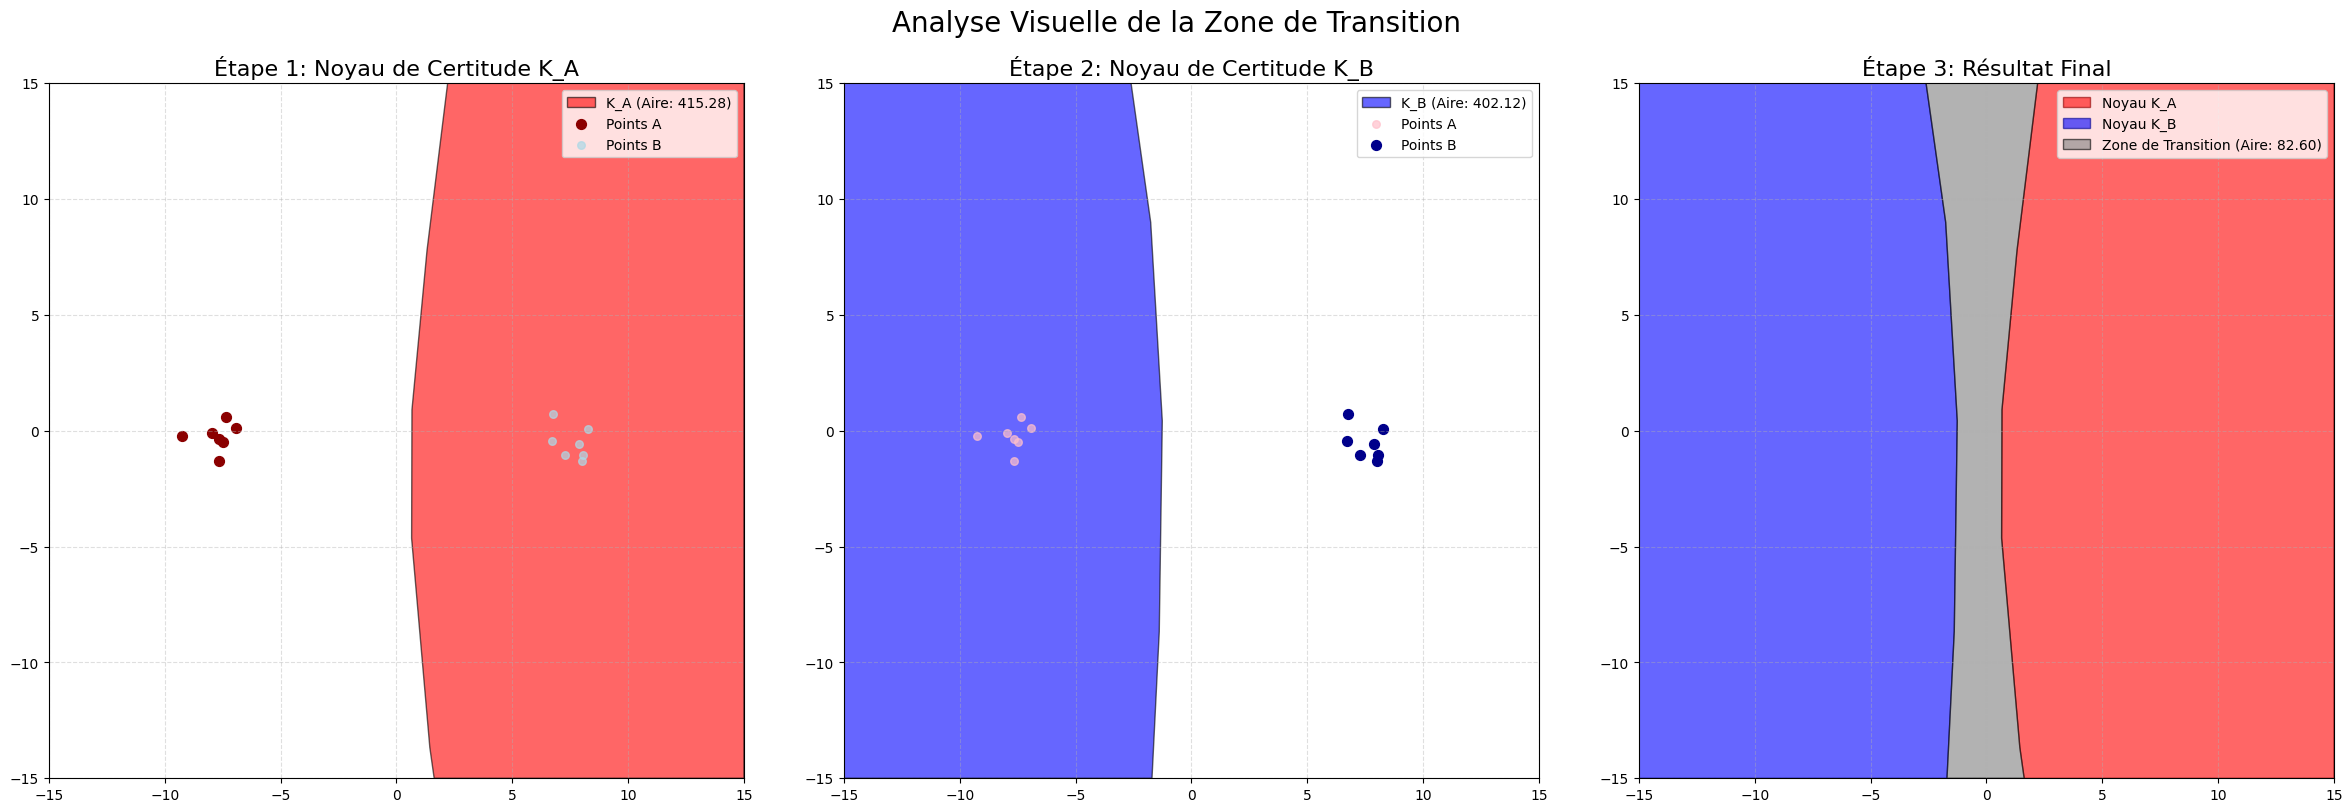

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import Point, Polygon as ShapelyPolygon, MultiPolygon
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore', category=UserWarning) # Shapely can be noisy

# --- Classe VoronoiTransitionZone (version minimale pour le diagnostic) ---
class VoronoiDiagnostic:
    def __init__(self, space_bounds=(-15, 15, -15, 15)):
        self.xmin, self.xmax, self.ymin, self.ymax = space_bounds
        self.bounding_box = ShapelyPolygon([
            (self.xmin, self.ymin), (self.xmax, self.ymin),
            (self.xmax, self.ymax), (self.xmin, self.ymax)
        ])
        print(f"--- Initialisation de l'Espace de Diagnostic ---")
        print(f"Limites de l'espace : ({self.xmin}, {self.xmax}, {self.ymin}, {self.ymax})")
        print(f"Aire totale de l'espace : {self.bounding_box.area:.2f}\n")

    def sample_from_disk(self, center, radius, n_samples):
        angles = np.random.uniform(0, 2 * np.pi, n_samples)
        radii = radius * np.sqrt(np.random.uniform(0, 1, n_samples))
        x = center[0] + radii * np.cos(angles)
        y = center[1] + radii * np.sin(angles)
        return np.column_stack((x, y))

    def compute_halfplane_polygon(self, p1, p2):
        """Calcule le demi-plan contenant les points plus proches de p1 que de p2,
           retourné comme un polygone Shapely intersecté avec la boîte."""
        midpoint = (p1 + p2) / 2
        direction = p1 - p2
        if np.linalg.norm(direction) < 1e-9: return self.bounding_box

        # Equation de la médiatrice: (x - midpoint) · direction = 0
        # A*x + B*y + C = 0, où A=direction[0], B=direction[1], C=-midpoint·direction
        A, B = direction[0], direction[1]
        C = -np.dot(midpoint, direction)

        # On veut le côté où (x - p1)^2 < (x - p2)^2, ce qui se simplifie en (x - midpoint) · direction < 0
        # Donc A*x + B*y + C < 0

        # Pour créer le polygone, on utilise les 4 coins de la bounding box
        corners = np.array([(self.xmin, self.ymin), (self.xmax, self.ymin),
                              (self.xmax, self.ymax), (self.xmin, self.ymax)])

        # Évalue la fonction du demi-plan aux coins
        corner_values = corners.dot(direction) - np.dot(midpoint, direction)

        # Les coins dans le bon demi-plan
        inside_corners = corners[corner_values < 1e-9]

        # Les coins en dehors
        outside_corners = corners[corner_values >= 1e-9]

        # Pour chaque arête reliant un coin "dedans" à un coin "dehors", on trouve l'intersection
        intersections = []
        for i in range(4):
            p_start, p_end = corners[i], corners[(i+1)%4]
            v_start, v_end = corner_values[i], corner_values[(i+1)%4]
            if (v_start < 0 and v_end >= 0) or (v_start >= 0 and v_end < 0):
                # t est la fraction le long de l'arête où se trouve l'intersection
                t = v_start / (v_start - v_end)
                intersection_point = p_start + t * (p_end - p_start)
                intersections.append(intersection_point)

        # Les sommets du polygone sont les coins intérieurs + les intersections
        poly_vertices = np.vstack([c for c in inside_corners] + intersections)

        # On trie les sommets pour former un polygone valide (enveloppe convexe)
        if len(poly_vertices) < 3: return ShapelyPolygon()
        hull = ShapelyPolygon(poly_vertices).convex_hull
        return hull

    def calculate_diagnostic(self, points_A, points_B):
        print("--- Début du Calcul Détaillé ---")
        n_A, n_B = len(points_A), len(points_B)
        total_intersections = n_A * n_B
        print(f"Nombre de points en A: {n_A}, en B: {n_B}")
        print(f"Nombre total de demi-plans à intersecter par noyau: {total_intersections}")

        # --- Calcul de K_A ---
        print("\n[1] Calcul du Noyau K_A (Intersection des H(a,b))")
        K_A = self.bounding_box
        for i, a in enumerate(points_A):
            for j, b in enumerate(points_B):
                halfplane = self.compute_halfplane_polygon(a, b)
                K_A = K_A.intersection(halfplane)
                if K_A.is_empty:
                    print(f"  -> Noyau K_A devenu VIDE à l'itération a{i+1}-b{j+1}. Arrêt prématuré.")
                    break
            if K_A.is_empty: break

        print(f"  Résultat K_A: Aire = {K_A.area:.4f}")
        if K_A.is_empty: print("  DIAGNOSTIC: Le noyau K_A s'est effondré.")

        # --- Calcul de K_B ---
        print("\n[2] Calcul du Noyau K_B (Intersection des H(b,a))")
        K_B = self.bounding_box
        for i, b in enumerate(points_B):
            for j, a in enumerate(points_A):
                halfplane = self.compute_halfplane_polygon(b, a)
                K_B = K_B.intersection(halfplane)
                if K_B.is_empty:
                    print(f"  -> Noyau K_B devenu VIDE à l'itération b{i+1}-a{j+1}. Arrêt prématuré.")
                    break
            if K_B.is_empty: break

        print(f"  Résultat K_B: Aire = {K_B.area:.4f}")
        if K_B.is_empty: print("  DIAGNOSTIC: Le noyau K_B s'est effondré.")

        # --- Union et Différence ---
        print("\n[3] Calcul de l'Union des Noyaux et de la Zone de Transition")
        kernels_union = unary_union([K_A, K_B])
        print(f"  Aire de K_A ∪ K_B: {kernels_union.area:.4f}")

        transition_zone = self.bounding_box.difference(kernels_union)
        print(f"  Zone de Transition = Espace Total - (K_A ∪ K_B)")
        print(f"  Aire de la Zone de Transition: {transition_zone.area:.4f}")

        print("\n--- Fin du Calcul Détaillé ---")
        return K_A, K_B, transition_zone, points_A, points_B

def plot_diagnostic(K_A, K_B, transition_zone, points_A, points_B, bounds, filename="diagnostic_plot.png"):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle("Analyse Visuelle de la Zone de Transition", fontsize=20)
    xmin, xmax, ymin, ymax = bounds

    # Helper pour plotter les polygones
    def plot_shapely(ax, geom, facecolor, edgecolor='black', label=''):
        """Helper pour plotter correctement les polygones Shapely avec Matplotlib."""
        if isinstance(geom, MultiPolygon):
            for poly in geom.geoms:
                # On transpose les coordonnées pour passer de (2, N) à (N, 2)
                xy = np.asarray(poly.exterior.xy).T
                ax.add_patch(Polygon(xy, facecolor=facecolor, alpha=0.6, ec=edgecolor))
        elif not geom.is_empty:
            # On transpose les coordonnées pour passer de (2, N) à (N, 2)
            xy = np.asarray(geom.exterior.xy).T
            ax.add_patch(Polygon(xy, facecolor=facecolor, alpha=0.6, ec=edgecolor, label=label))
    # --- Plot 1: Noyau K_A ---
    ax = axes[0]
    ax.set_title("Étape 1: Noyau de Certitude K_A", fontsize=16)
    plot_shapely(ax, K_A, 'red', label=f'K_A (Aire: {K_A.area:.2f})')
    ax.scatter(points_A[:, 0], points_A[:, 1], c='darkred', s=50, label='Points A')
    ax.scatter(points_B[:, 0], points_B[:, 1], c='lightblue', s=30, alpha=0.7, label='Points B')

    # --- Plot 2: Noyau K_B ---
    ax = axes[1]
    ax.set_title("Étape 2: Noyau de Certitude K_B", fontsize=16)
    plot_shapely(ax, K_B, 'blue', label=f'K_B (Aire: {K_B.area:.2f})')
    ax.scatter(points_A[:, 0], points_A[:, 1], c='pink', s=30, alpha=0.7, label='Points A')
    ax.scatter(points_B[:, 0], points_B[:, 1], c='darkblue', s=50, label='Points B')

    # --- Plot 3: Résultat Final ---
    ax = axes[2]
    ax.set_title("Étape 3: Résultat Final", fontsize=16)
    plot_shapely(ax, K_A, 'red', 'darkred', label=f'Noyau K_A')
    plot_shapely(ax, K_B, 'blue', 'darkblue', label=f'Noyau K_B')
    plot_shapely(ax, transition_zone, 'gray', 'black', label=f'Zone de Transition (Aire: {transition_zone.area:.2f})')

    for ax in axes:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_aspect('equal')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=150)
    print(f"\nVisualisation détaillée enregistrée sous : '{filename}'")
    plt.show()


# --- PARAMÈTRES DE L'EXPÉRIENCE (MODIFIEZ ICI) ---
# Cas 1: "Effondrement Probable" - Régions proches et larges
PARAMS_CAS_1 = {
    "center_A": (-4, 0), "radius_A": 2.5,
    "center_B": (4, 0),  "radius_B": 2.5,
    "n_samples": 10,
    "filename": "diagnostic_effondrement.png"
}

# Cas 2: "Noyaux Probables" - Régions distantes et petites
PARAMS_CAS_2 = {
    "center_A": (-8, 0), "radius_A": 1.5,
    "center_B": (8, 0),  "radius_B": 1.5,
    "n_samples": 7,
    "filename": "diagnostic_noyaux_visibles.png"
}

if __name__ == "__main__":
    # --- Choisissez le cas à exécuter ---
    params = PARAMS_CAS_2
    # params = PARAMS_CAS_1

    # Initialisation
    diagnostic_tool = VoronoiDiagnostic()

    # Échantillonnage
    points_A = diagnostic_tool.sample_from_disk(params["center_A"], params["radius_A"], params["n_samples"])
    points_B = diagnostic_tool.sample_from_disk(params["center_B"], params["radius_B"], params["n_samples"])

    # Calcul et analyse
    K_A, K_B, T_Zone, p_A, p_B = diagnostic_tool.calculate_diagnostic(points_A, points_B)

    # Visualisation
    plot_diagnostic(K_A, K_B, T_Zone, p_A, p_B,
                    bounds=(diagnostic_tool.xmin, diagnostic_tool.xmax, diagnostic_tool.ymin, diagnostic_tool.ymax),
                    filename=params["filename"])